# The Gresho Vortex Test

This problem tests the code for conservation of angular momentum and for its ability to maintain a dynamical equilibrium state. To do this, we initialize a stable, time-independent vortex by balancing the centrifugal force with the gradient of the initial pressure profile. Explicitly, we set:
$$ v_\theta(r)=   \left\{
\begin{array}{ll}
      5r & 0\leq r < 0.2 \\
      2-5r & 0.2 \leq r < 0.4 \\
      0 & r > 0.4 \\
\end{array} 
\right.  
$$
In other words, this test initializes a radially varying angular velocity profile that grows linearly till a peak at $r=0.2$ (the midpoint of the disk), after which it decreases linearly to the edge/rim of the disk. The corresponding pressure profile (that balances the centrifugal force generated by this rotational velocity) is:
$$ P(r)=   \left\{
\begin{array}{ll}
      5+\frac{25}{2}r^2 & 0\leq r < 0.2 \\
      9+\frac{25}{2}r^2-20r+4\ln\big(\frac{r}{0.2}\big) & 0.2 \leq r < 0.4 \\
      3+4\ln(2) & r > 0.4 \\
\end{array} 
\right.  
$$
Because this initial condition is pure rotation (a vortex), we expect that the vortex should maintain its shape throughout the simulation.

### Implementation
Again, we begin by importing the relevant packages. As before (see Sod Test), this problem can be easily run in parallel – one must simply combine the necessary code blocks into a single python program and use the command
```
mpirun -n 4 python your_program_name.py
``` 
and the code will recognize that you are running in parallel and will alter the computation accordingly.

In [1]:
import phd
import numpy as np

Next we want to write a method to set up our initial conditions. Because the code takes its inputs in cartesian coordinates, we can compute the angular velocity in polar coordinates and convert back to the $xy$ components for the `particles` object.

In [2]:
def create_particles(dim=2, nx=45, Lx=1., gamma=1.4, units = "cgs"):

    dx = Lx/nx # spacing between particles
    n = nx*nx  # number of points

    # create particle container, which implicitly assumes cgs
    particles, units = phd.HydroParticleCreator(n, dim=2)
    part = 0
    for i in range(nx):
        for j in range(nx):

            x = (i+0.5)*dx - 0.5
            y = (j+0.5)*dx - 0.5

            # convert to polar coordinates
            theta = np.arctan2(y, x)                         
            r = np.sqrt(x**2 + y**2)

            if 0 <= r < 0.2:
                vtheta = 5*r
                press = 5 + 25./2*r**2

            elif 0.2 <= r < 0.4:
                vtheta = 2 - 5*r
                press = 9 + 25./2*r**2 - 20.*r + 4*np.log(r/0.2)

            else:
                vtheta = 0.
                press = 3 + 4*np.log(2)

            particles["position-x"][part] = x + 0.5
            particles["position-y"][part] = y + 0.5
            
            # recover the cartesian components
            particles["velocity-x"][part] = -np.sin(theta)*vtheta        
            particles["velocity-y"][part] =  np.cos(theta)*vtheta
            particles["pressure"][part] = press 
            particles["ids"][part] = part
            part += 1

    # set ambient values
    particles["density"][:] = 1.0

    return particles, units

The rest is easy! We can build all the different components of the simulation (i.e. domain, Riemann solver, output information, stoppage criteria, etc.). With this problem, we can use the `TimeInterval` method, which allows us to specify how frequently the simulation should produce output files (in this case, at an interval of 0.5). Unlike with the Sod Shock Tube, here we will just proceed with the ``Units`` object returned by the particle creator method.

In [3]:
dim = 2; gamma = 1.4
particles, units = phd.distribute_initial_particles(
                    create_particles, dim=dim, gamma=gamma, units = "cgs")

# computation related to boundaries
domain_manager = phd.DomainManager(
        xmin=[0., 0.], xmax=[1., 1.],
        initial_radius=0.1)

# create voronoi mesh
mesh = phd.Mesh()

# computation
integrator = phd.MovingMeshMUSCLHancock()
integrator.set_mesh(mesh)
integrator.set_riemann(phd.HLLC())
integrator.set_particles(particles)
integrator.set_domain_manager(domain_manager)
integrator.set_boundary_condition(phd.Periodic())
integrator.set_reconstruction(phd.PieceWiseLinear())
integrator.set_equation_state(phd.IdealGas(gamma=gamma))
integrator.set_units(units)

sim_name = "gresho"
if phd._in_parallel:
    integrator.set_load_balance(phd.LoadBalance())
    sim_name = "mpi_gresho"

# add finish criteria
simulation_time_manager = phd.SimulationTimeManager()
simulation_time_manager.add_finish(phd.Time(time_max=3.0))

# output initial state
output = phd.InitialOutput()
output.set_writer(phd.Hdf5())
simulation_time_manager.add_output(output)

# output last step
output = phd.FinalOutput()
output.set_writer(phd.Hdf5())
simulation_time_manager.add_output(output)

# output every 0.5 time interval
output = phd.TimeInterval(time_interval=0.5)
output.set_writer(phd.Hdf5())
simulation_time_manager.add_output(output)

Finally, we sit back and run the simulation.

In [4]:
# Create simulator
simulation = phd.Simulation(simulation_name=sim_name)
simulation.set_integrator(integrator)
simulation.set_simulation_time_manager(simulation_time_manager)
simulation.initialize()
simulation.solve()

phd: [INFO     ] 2021-04-12 18:53:59,777: 

 __________.__         .___
\______   \  |__    __| _/
 |     ___/  |  \  / __ |
 |    |   |   Y  \/ /_/ |
 |____|   |___|  /\____ |
               \/      \/
Welcome to Python Hydro-Dynamics!

Simulation Information
------------------------------
Running in serial
Log file saved at: gresho.log
Problem solving: gresho
Output data will be saved at: gresho_output

Classes used in the simulation
------------------------------
boundary_condition: Periodic
domain_manager: DomainManager
equation_state: IdealGas
integrator: MovingMeshMUSCLHancock
mesh: Mesh
particles: CarrayContainer
reconstruction: PieceWiseLinear
riemann: HLLC

phd: [INFO     ] 2021-04-12 18:53:59,782: IntegrateBase: Building initial mesh
phd: [INFO     ] 2021-04-12 18:53:59,783: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:53:59,825: hdf5 format: Writting initial_output0000.hdf5
phd: [INFO     ] 2021-04-12 18:53:59,851: Beginning integration loop
phd: [INFO     ] 2

phd: [INFO     ] 2021-04-12 18:54:00,203: Hydro dt: 0.002198
phd: [INFO     ] 2021-04-12 18:54:00,204: Starting iteration: 10 time: 0.022011 dt: 0.002198
phd: [INFO     ] 2021-04-12 18:54:00,204: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:00,206: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:00,220: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:00,223: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:00,224: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:00,226: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:00,248: Hydro dt: 0.002197
phd: [INFO     ] 2021-04-12 18:54:00,249: Starting iteration: 11 time: 0.024208 dt: 0.002197
phd: [INFO     ] 2021-04-12 18:54:00,250: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:00,252: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-0

phd: [INFO     ] 2021-04-12 18:54:00,628: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:00,630: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:00,630: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:00,632: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:00,655: Hydro dt: 0.002193
phd: [INFO     ] 2021-04-12 18:54:00,656: Starting iteration: 22 time: 0.048354 dt: 0.002193
phd: [INFO     ] 2021-04-12 18:54:00,656: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:00,658: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:00,665: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:00,666: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:00,667: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:00,669: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54

phd: [INFO     ] 2021-04-12 18:54:01,025: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:01,045: Hydro dt: 0.002191
phd: [INFO     ] 2021-04-12 18:54:01,045: Starting iteration: 33 time: 0.072463 dt: 0.002191
phd: [INFO     ] 2021-04-12 18:54:01,046: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:01,047: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:01,053: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:01,055: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:01,055: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:01,057: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:01,077: Hydro dt: 0.002191
phd: [INFO     ] 2021-04-12 18:54:01,077: Starting iteration: 34 time: 0.074654 dt: 0.002191
phd: [INFO     ] 2021-04-12 18:54:01,078: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:01,079

phd: [INFO     ] 2021-04-12 18:54:01,457: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:01,470: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:01,472: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:01,473: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:01,475: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:01,498: Hydro dt: 0.002191
phd: [INFO     ] 2021-04-12 18:54:01,499: Starting iteration: 45 time: 0.098758 dt: 0.002191
phd: [INFO     ] 2021-04-12 18:54:01,499: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:01,501: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:01,508: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:01,509: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:01,510: HLLC: Starting riemann
phd: [INFO     ]

phd: [INFO     ] 2021-04-12 18:54:01,856: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:01,857: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:01,878: Hydro dt: 0.002183
phd: [INFO     ] 2021-04-12 18:54:01,879: Starting iteration: 56 time: 0.122850 dt: 0.002183
phd: [INFO     ] 2021-04-12 18:54:01,879: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:01,881: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:01,887: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:01,888: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:01,889: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:01,891: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:01,911: Hydro dt: 0.002181
phd: [INFO     ] 2021-04-12 18:54:01,912: Starting iteration: 57 time: 0.125033 dt: 0.002181
phd: [INFO     ] 2021-04-12 18:54:01,912: MovingMeshMUSCLHanco

phd: [INFO     ] 2021-04-12 18:54:02,255: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:02,256: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:02,262: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:02,264: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:02,264: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:02,266: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:02,286: Hydro dt: 0.002153
phd: [INFO     ] 2021-04-12 18:54:02,287: Starting iteration: 68 time: 0.148889 dt: 0.002153
phd: [INFO     ] 2021-04-12 18:54:02,287: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:02,289: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:02,295: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:02,296: PieceWiseLinear: Starting temporal reconstru

phd: [INFO     ] 2021-04-12 18:54:02,635: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:02,636: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:02,637: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:02,658: Hydro dt: 0.002106
phd: [INFO     ] 2021-04-12 18:54:02,658: Starting iteration: 79 time: 0.172150 dt: 0.002106
phd: [INFO     ] 2021-04-12 18:54:02,659: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:02,661: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:02,668: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:02,669: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:02,669: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:02,671: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:02,697: Hydro dt: 0.002104
phd: [INFO     ] 2021-04-12 18:54:02,698: Starting iteration: 8

phd: [INFO     ] 2021-04-12 18:54:03,031: Starting iteration: 90 time: 0.194816 dt: 0.002009
phd: [INFO     ] 2021-04-12 18:54:03,032: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:03,033: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:03,040: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:03,041: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:03,042: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:03,043: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:03,064: Hydro dt: 0.002006
phd: [INFO     ] 2021-04-12 18:54:03,064: Starting iteration: 91 time: 0.196825 dt: 0.002006
phd: [INFO     ] 2021-04-12 18:54:03,065: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:03,066: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:03,072: PieceWiseLinear: Starting spatial reconstr

phd: [INFO     ] 2021-04-12 18:54:03,412: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:03,413: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:03,414: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:03,416: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:03,436: Hydro dt: 0.001963
phd: [INFO     ] 2021-04-12 18:54:03,436: Starting iteration: 102 time: 0.218738 dt: 0.001963
phd: [INFO     ] 2021-04-12 18:54:03,437: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:03,438: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:03,444: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:03,446: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:03,447: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:03,448: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:5

phd: [INFO     ] 2021-04-12 18:54:03,782: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:03,803: Hydro dt: 0.001891
phd: [INFO     ] 2021-04-12 18:54:03,803: Starting iteration: 113 time: 0.239975 dt: 0.001891
phd: [INFO     ] 2021-04-12 18:54:03,804: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:03,805: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:03,812: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:03,813: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:03,814: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:03,816: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:03,836: Hydro dt: 0.001885
phd: [INFO     ] 2021-04-12 18:54:03,837: Starting iteration: 114 time: 0.241866 dt: 0.001885
phd: [INFO     ] 2021-04-12 18:54:03,837: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:03,8

phd: [INFO     ] 2021-04-12 18:54:04,198: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:04,205: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:04,206: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:04,206: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:04,208: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:04,228: Hydro dt: 0.001897
phd: [INFO     ] 2021-04-12 18:54:04,230: Starting iteration: 125 time: 0.262668 dt: 0.001897
phd: [INFO     ] 2021-04-12 18:54:04,230: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:04,232: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:04,238: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:04,240: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:04,240: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-04-12 18:54:04,598: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:04,600: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:04,620: Hydro dt: 0.001857
phd: [INFO     ] 2021-04-12 18:54:04,621: Starting iteration: 136 time: 0.283377 dt: 0.001857
phd: [INFO     ] 2021-04-12 18:54:04,621: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:04,623: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:04,629: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:04,631: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:04,631: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:04,633: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:04,652: Hydro dt: 0.001852
phd: [INFO     ] 2021-04-12 18:54:04,653: Starting iteration: 137 time: 0.285234 dt: 0.001852
phd: [INFO     ] 2021-04-12 18:54:04,653: MovingMeshMUSCLHan

phd: [INFO     ] 2021-04-12 18:54:04,991: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:04,993: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:05,001: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:05,002: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:05,003: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:05,005: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:05,026: Hydro dt: 0.001900
phd: [INFO     ] 2021-04-12 18:54:05,028: Starting iteration: 148 time: 0.306197 dt: 0.001900
phd: [INFO     ] 2021-04-12 18:54:05,029: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:05,031: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:05,037: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:05,039: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-04-12 18:54:05,388: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:05,388: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:05,390: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:05,411: Hydro dt: 0.001856
phd: [INFO     ] 2021-04-12 18:54:05,412: Starting iteration: 159 time: 0.326863 dt: 0.001856
phd: [INFO     ] 2021-04-12 18:54:05,412: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:05,414: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:05,421: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:05,422: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:05,423: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:05,424: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:05,444: Hydro dt: 0.001851
phd: [INFO     ] 2021-04-12 18:54:05,445: Starting iteration: 

phd: [INFO     ] 2021-04-12 18:54:05,781: Starting iteration: 170 time: 0.347160 dt: 0.001823
phd: [INFO     ] 2021-04-12 18:54:05,781: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:05,783: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:05,789: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:05,791: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:05,792: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:05,793: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:05,813: Hydro dt: 0.001818
phd: [INFO     ] 2021-04-12 18:54:05,814: Starting iteration: 171 time: 0.348982 dt: 0.001818
phd: [INFO     ] 2021-04-12 18:54:05,814: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:05,816: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:05,822: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-04-12 18:54:06,149: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:06,151: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:06,152: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:06,153: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:06,173: Hydro dt: 0.001783
phd: [INFO     ] 2021-04-12 18:54:06,173: Starting iteration: 182 time: 0.368787 dt: 0.001783
phd: [INFO     ] 2021-04-12 18:54:06,174: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:06,175: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:06,182: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:06,183: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:06,184: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:06,185: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:5

phd: [INFO     ] 2021-04-12 18:54:06,554: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:06,574: Hydro dt: 0.001845
phd: [INFO     ] 2021-04-12 18:54:06,575: Starting iteration: 193 time: 0.388350 dt: 0.001845
phd: [INFO     ] 2021-04-12 18:54:06,575: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:06,576: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:06,582: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:06,584: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:06,585: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:06,586: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:06,605: Hydro dt: 0.001840
phd: [INFO     ] 2021-04-12 18:54:06,606: Starting iteration: 194 time: 0.390195 dt: 0.001840
phd: [INFO     ] 2021-04-12 18:54:06,606: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:06,6

phd: [INFO     ] 2021-04-12 18:54:06,960: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:06,967: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:06,968: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:06,969: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:06,970: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:06,990: Hydro dt: 0.001775
phd: [INFO     ] 2021-04-12 18:54:06,991: Starting iteration: 205 time: 0.410111 dt: 0.001775
phd: [INFO     ] 2021-04-12 18:54:06,991: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:06,993: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:07,000: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:07,001: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:07,002: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-04-12 18:54:07,427: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:07,430: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:07,454: Hydro dt: 0.001738
phd: [INFO     ] 2021-04-12 18:54:07,454: Starting iteration: 216 time: 0.429385 dt: 0.001738
phd: [INFO     ] 2021-04-12 18:54:07,455: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:07,457: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:07,464: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:07,466: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:07,467: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:07,469: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:07,492: Hydro dt: 0.001735
phd: [INFO     ] 2021-04-12 18:54:07,492: Starting iteration: 217 time: 0.431122 dt: 0.001735
phd: [INFO     ] 2021-04-12 18:54:07,493: MovingMeshMUSCLHan

phd: [INFO     ] 2021-04-12 18:54:07,861: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:07,863: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:07,870: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:07,871: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:07,872: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:07,874: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:07,895: Hydro dt: 0.001744
phd: [INFO     ] 2021-04-12 18:54:07,895: Starting iteration: 228 time: 0.450209 dt: 0.001744
phd: [INFO     ] 2021-04-12 18:54:07,896: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:07,897: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:07,904: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:07,906: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-04-12 18:54:08,257: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:08,265: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:08,266: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:08,290: Hydro dt: 0.001760
phd: [INFO     ] 2021-04-12 18:54:08,291: Starting iteration: 239 time: 0.469495 dt: 0.001760
phd: [INFO     ] 2021-04-12 18:54:08,291: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:08,293: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:08,300: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:08,302: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:08,303: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:08,304: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:08,325: Hydro dt: 0.001762
phd: [INFO     ] 2021-04-12 18:54:08,325: Starting iteration: 

phd: [INFO     ] 2021-04-12 18:54:08,677: Starting iteration: 250 time: 0.488927 dt: 0.001774
phd: [INFO     ] 2021-04-12 18:54:08,677: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:08,679: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:08,686: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:08,688: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:08,689: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:08,690: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:08,710: Hydro dt: 0.001774
phd: [INFO     ] 2021-04-12 18:54:08,711: Starting iteration: 251 time: 0.490701 dt: 0.001774
phd: [INFO     ] 2021-04-12 18:54:08,712: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:08,714: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:08,720: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-04-12 18:54:09,073: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:09,084: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:09,087: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:09,087: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:09,090: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:09,111: Hydro dt: 0.001759
phd: [INFO     ] 2021-04-12 18:54:09,112: Starting iteration: 262 time: 0.508833 dt: 0.001759
phd: [INFO     ] 2021-04-12 18:54:09,112: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:09,114: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:09,121: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:09,122: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:09,123: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-04-12 18:54:09,452: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:09,454: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:09,474: Hydro dt: 0.001725
phd: [INFO     ] 2021-04-12 18:54:09,475: Starting iteration: 273 time: 0.528007 dt: 0.001725
phd: [INFO     ] 2021-04-12 18:54:09,475: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:09,477: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:09,483: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:09,485: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:09,486: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:09,487: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:09,507: Hydro dt: 0.001727
phd: [INFO     ] 2021-04-12 18:54:09,508: Starting iteration: 274 time: 0.529731 dt: 0.001727
phd: [INFO     ] 2021-04-12 18:54:09,508: MovingMeshMUSCLHan

phd: [INFO     ] 2021-04-12 18:54:09,866: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:09,868: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:09,874: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:09,875: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:09,876: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:09,878: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:09,898: Hydro dt: 0.001708
phd: [INFO     ] 2021-04-12 18:54:09,899: Starting iteration: 285 time: 0.548605 dt: 0.001708
phd: [INFO     ] 2021-04-12 18:54:09,900: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:09,901: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:09,908: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:09,909: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-04-12 18:54:10,238: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:10,239: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:10,241: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:10,260: Hydro dt: 0.001773
phd: [INFO     ] 2021-04-12 18:54:10,260: Starting iteration: 296 time: 0.567790 dt: 0.001773
phd: [INFO     ] 2021-04-12 18:54:10,261: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:10,262: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:10,269: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:10,270: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:10,271: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:10,272: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:10,292: Hydro dt: 0.001771
phd: [INFO     ] 2021-04-12 18:54:10,292: Starting iteration: 

phd: [INFO     ] 2021-04-12 18:54:10,622: Starting iteration: 307 time: 0.587188 dt: 0.001758
phd: [INFO     ] 2021-04-12 18:54:10,622: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:10,623: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:10,630: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:10,632: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:10,632: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:10,634: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:10,654: Hydro dt: 0.001759
phd: [INFO     ] 2021-04-12 18:54:10,654: Starting iteration: 308 time: 0.588947 dt: 0.001759
phd: [INFO     ] 2021-04-12 18:54:10,655: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:10,656: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:10,663: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-04-12 18:54:11,014: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:11,016: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:11,017: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:11,018: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:11,039: Hydro dt: 0.001781
phd: [INFO     ] 2021-04-12 18:54:11,040: Starting iteration: 319 time: 0.608374 dt: 0.001781
phd: [INFO     ] 2021-04-12 18:54:11,040: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:11,042: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:11,050: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:11,051: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:11,052: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:11,054: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:5

phd: [INFO     ] 2021-04-12 18:54:11,396: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:11,416: Hydro dt: 0.001835
phd: [INFO     ] 2021-04-12 18:54:11,416: Starting iteration: 330 time: 0.628212 dt: 0.001835
phd: [INFO     ] 2021-04-12 18:54:11,417: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:11,419: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:11,425: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:11,426: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:11,427: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:11,429: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:11,449: Hydro dt: 0.001842
phd: [INFO     ] 2021-04-12 18:54:11,450: Starting iteration: 331 time: 0.630047 dt: 0.001842
phd: [INFO     ] 2021-04-12 18:54:11,450: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:11,4

phd: [INFO     ] 2021-04-12 18:54:11,809: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:11,816: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:11,818: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:11,819: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:11,821: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:11,842: Hydro dt: 0.001875
phd: [INFO     ] 2021-04-12 18:54:11,843: Starting iteration: 342 time: 0.650571 dt: 0.001875
phd: [INFO     ] 2021-04-12 18:54:11,843: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:11,847: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:11,853: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:11,855: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:11,856: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-04-12 18:54:12,250: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:12,252: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:12,289: Hydro dt: 0.001879
phd: [INFO     ] 2021-04-12 18:54:12,289: Starting iteration: 353 time: 0.671199 dt: 0.001879
phd: [INFO     ] 2021-04-12 18:54:12,290: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:12,291: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:12,299: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:12,300: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:12,301: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:12,302: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:12,324: Hydro dt: 0.001881
phd: [INFO     ] 2021-04-12 18:54:12,324: Starting iteration: 354 time: 0.673078 dt: 0.001881
phd: [INFO     ] 2021-04-12 18:54:12,324: MovingMeshMUSCLHan

phd: [INFO     ] 2021-04-12 18:54:12,690: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:12,691: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:12,697: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:12,699: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:12,700: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:12,702: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:12,724: Hydro dt: 0.001865
phd: [INFO     ] 2021-04-12 18:54:12,725: Starting iteration: 365 time: 0.693724 dt: 0.001865
phd: [INFO     ] 2021-04-12 18:54:12,726: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:12,728: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:12,736: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:12,738: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-04-12 18:54:13,108: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:13,109: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:13,824: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:13,860: Hydro dt: 0.001819
phd: [INFO     ] 2021-04-12 18:54:13,860: Starting iteration: 376 time: 0.714033 dt: 0.001819
phd: [INFO     ] 2021-04-12 18:54:13,861: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:13,863: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:13,871: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:13,872: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:13,873: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:13,875: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:13,897: Hydro dt: 0.001815
phd: [INFO     ] 2021-04-12 18:54:13,897: Starting iteration: 

phd: [INFO     ] 2021-04-12 18:54:14,277: Starting iteration: 387 time: 0.733840 dt: 0.001785
phd: [INFO     ] 2021-04-12 18:54:14,278: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:14,280: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:14,286: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:14,287: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:14,288: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:14,289: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:14,309: Hydro dt: 0.001784
phd: [INFO     ] 2021-04-12 18:54:14,309: Starting iteration: 388 time: 0.735625 dt: 0.001784
phd: [INFO     ] 2021-04-12 18:54:14,310: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:14,311: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:14,317: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-04-12 18:54:14,675: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:14,677: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:14,678: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:14,680: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:14,700: Hydro dt: 0.001764
phd: [INFO     ] 2021-04-12 18:54:14,701: Starting iteration: 399 time: 0.755212 dt: 0.001764
phd: [INFO     ] 2021-04-12 18:54:14,701: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:14,703: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:14,709: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:14,711: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:14,711: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:14,713: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:5

phd: [INFO     ] 2021-04-12 18:54:15,065: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:15,085: Hydro dt: 0.001759
phd: [INFO     ] 2021-04-12 18:54:15,086: Starting iteration: 410 time: 0.774579 dt: 0.001759
phd: [INFO     ] 2021-04-12 18:54:15,086: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:15,089: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:15,096: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:15,097: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:15,098: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:15,099: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:15,119: Hydro dt: 0.001759
phd: [INFO     ] 2021-04-12 18:54:15,120: Starting iteration: 411 time: 0.776338 dt: 0.001759
phd: [INFO     ] 2021-04-12 18:54:15,120: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:15,1

phd: [INFO     ] 2021-04-12 18:54:15,456: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:15,463: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:15,465: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:15,466: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:15,467: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:15,488: Hydro dt: 0.001772
phd: [INFO     ] 2021-04-12 18:54:15,488: Starting iteration: 422 time: 0.795755 dt: 0.001772
phd: [INFO     ] 2021-04-12 18:54:15,488: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:15,490: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:15,496: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:15,498: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:15,498: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-04-12 18:54:15,838: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:15,840: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:15,859: Hydro dt: 0.001788
phd: [INFO     ] 2021-04-12 18:54:15,860: Starting iteration: 433 time: 0.815326 dt: 0.001788
phd: [INFO     ] 2021-04-12 18:54:15,860: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:15,862: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:15,868: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:15,870: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:15,870: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:15,872: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:15,891: Hydro dt: 0.001787
phd: [INFO     ] 2021-04-12 18:54:15,892: Starting iteration: 434 time: 0.817114 dt: 0.001787
phd: [INFO     ] 2021-04-12 18:54:15,892: MovingMeshMUSCLHan

phd: [INFO     ] 2021-04-12 18:54:16,220: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:16,221: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:16,227: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:16,228: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:16,229: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:16,230: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:16,250: Hydro dt: 0.001761
phd: [INFO     ] 2021-04-12 18:54:16,250: Starting iteration: 445 time: 0.836588 dt: 0.001761
phd: [INFO     ] 2021-04-12 18:54:16,250: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:16,252: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:16,258: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:16,259: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-04-12 18:54:16,597: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:16,597: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:16,599: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:16,619: Hydro dt: 0.001757
phd: [INFO     ] 2021-04-12 18:54:16,620: Starting iteration: 456 time: 0.855940 dt: 0.001757
phd: [INFO     ] 2021-04-12 18:54:16,621: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:16,623: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:16,629: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:16,631: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:16,632: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:16,633: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:16,654: Hydro dt: 0.001758
phd: [INFO     ] 2021-04-12 18:54:16,655: Starting iteration: 

phd: [INFO     ] 2021-04-12 18:54:16,982: Starting iteration: 467 time: 0.875500 dt: 0.001796
phd: [INFO     ] 2021-04-12 18:54:16,982: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:16,984: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:16,990: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:16,991: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:16,991: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:16,993: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:17,012: Hydro dt: 0.001800
phd: [INFO     ] 2021-04-12 18:54:17,013: Starting iteration: 468 time: 0.877295 dt: 0.001800
phd: [INFO     ] 2021-04-12 18:54:17,013: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:17,014: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:17,021: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-04-12 18:54:17,354: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:17,355: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:17,356: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:17,357: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:17,377: Hydro dt: 0.001804
phd: [INFO     ] 2021-04-12 18:54:17,377: Starting iteration: 479 time: 0.897132 dt: 0.001804
phd: [INFO     ] 2021-04-12 18:54:17,377: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:17,379: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:17,385: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:17,386: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:17,387: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:17,388: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:5

phd: [INFO     ] 2021-04-12 18:54:17,695: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:17,714: Hydro dt: 0.001803
phd: [INFO     ] 2021-04-12 18:54:17,715: Starting iteration: 490 time: 0.916974 dt: 0.001803
phd: [INFO     ] 2021-04-12 18:54:17,715: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:17,717: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:17,723: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:17,724: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:17,724: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:17,726: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:17,746: Hydro dt: 0.001802
phd: [INFO     ] 2021-04-12 18:54:17,746: Starting iteration: 491 time: 0.918777 dt: 0.001802
phd: [INFO     ] 2021-04-12 18:54:17,746: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:17,7

phd: [INFO     ] 2021-04-12 18:54:18,089: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:18,096: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:18,097: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:18,098: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:18,100: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:18,120: Hydro dt: 0.001729
phd: [INFO     ] 2021-04-12 18:54:18,121: Starting iteration: 502 time: 0.938218 dt: 0.001729
phd: [INFO     ] 2021-04-12 18:54:18,122: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:18,124: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:18,130: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:18,132: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:18,134: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-04-12 18:54:18,474: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:18,475: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:18,494: Hydro dt: 0.001697
phd: [INFO     ] 2021-04-12 18:54:18,494: Starting iteration: 513 time: 0.957040 dt: 0.001697
phd: [INFO     ] 2021-04-12 18:54:18,495: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:18,496: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:18,502: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:18,503: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:18,504: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:18,505: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:18,524: Hydro dt: 0.001696
phd: [INFO     ] 2021-04-12 18:54:18,524: Starting iteration: 514 time: 0.958737 dt: 0.001696
phd: [INFO     ] 2021-04-12 18:54:18,525: MovingMeshMUSCLHan

phd: [INFO     ] 2021-04-12 18:54:18,842: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:18,844: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:18,850: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:18,851: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:18,852: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:18,853: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:18,873: Hydro dt: 0.001722
phd: [INFO     ] 2021-04-12 18:54:18,873: Starting iteration: 525 time: 0.977461 dt: 0.001722
phd: [INFO     ] 2021-04-12 18:54:18,873: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:18,875: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:18,881: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:18,882: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-04-12 18:54:19,196: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:19,197: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:19,198: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:19,217: Hydro dt: 0.001772
phd: [INFO     ] 2021-04-12 18:54:19,218: Starting iteration: 536 time: 0.996694 dt: 0.001772
phd: [INFO     ] 2021-04-12 18:54:19,218: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:19,220: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:19,225: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:19,227: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:19,227: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:19,229: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:19,248: Hydro dt: 0.001771
phd: [INFO     ] 2021-04-12 18:54:19,249: Starting iteration: 

phd: [INFO     ] 2021-04-12 18:54:19,553: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:19,573: Hydro dt: 0.001760
phd: [INFO     ] 2021-04-12 18:54:19,573: Starting iteration: 547 time: 1.015888 dt: 0.001760
phd: [INFO     ] 2021-04-12 18:54:19,573: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:19,575: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:19,581: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:19,582: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:19,582: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:19,584: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:19,603: Hydro dt: 0.001759
phd: [INFO     ] 2021-04-12 18:54:19,603: Starting iteration: 548 time: 1.017649 dt: 0.001759
phd: [INFO     ] 2021-04-12 18:54:19,603: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:19,6

phd: [INFO     ] 2021-04-12 18:54:19,928: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:19,934: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:19,936: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:19,937: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:19,938: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:19,957: Hydro dt: 0.001750
phd: [INFO     ] 2021-04-12 18:54:19,957: Starting iteration: 559 time: 1.036955 dt: 0.001750
phd: [INFO     ] 2021-04-12 18:54:19,958: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:19,959: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:19,965: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:19,967: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:19,979: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-04-12 18:54:20,289: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:20,291: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:20,310: Hydro dt: 0.001753
phd: [INFO     ] 2021-04-12 18:54:20,310: Starting iteration: 570 time: 1.056216 dt: 0.001753
phd: [INFO     ] 2021-04-12 18:54:20,311: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:20,312: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:20,318: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:20,319: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:20,320: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:20,321: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:20,340: Hydro dt: 0.001754
phd: [INFO     ] 2021-04-12 18:54:20,341: Starting iteration: 571 time: 1.057969 dt: 0.001754
phd: [INFO     ] 2021-04-12 18:54:20,341: MovingMeshMUSCLHan

phd: [INFO     ] 2021-04-12 18:54:20,651: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:20,652: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:20,658: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:20,659: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:20,660: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:20,661: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:20,680: Hydro dt: 0.001761
phd: [INFO     ] 2021-04-12 18:54:20,681: Starting iteration: 582 time: 1.077334 dt: 0.001761
phd: [INFO     ] 2021-04-12 18:54:20,681: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:20,682: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:20,688: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:20,689: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-04-12 18:54:21,065: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:21,069: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:21,072: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:21,096: Hydro dt: 0.001738
phd: [INFO     ] 2021-04-12 18:54:21,097: Starting iteration: 593 time: 1.096567 dt: 0.001738
phd: [INFO     ] 2021-04-12 18:54:21,097: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:21,099: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:21,105: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:21,107: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:21,107: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:21,109: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:21,129: Hydro dt: 0.001734
phd: [INFO     ] 2021-04-12 18:54:21,130: Starting iteration: 

phd: [INFO     ] 2021-04-12 18:54:21,508: Starting iteration: 604 time: 1.115647 dt: 0.001734
phd: [INFO     ] 2021-04-12 18:54:21,509: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:21,510: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:21,517: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:21,518: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:21,519: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:21,520: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:21,540: Hydro dt: 0.001736
phd: [INFO     ] 2021-04-12 18:54:21,540: Starting iteration: 605 time: 1.117381 dt: 0.001736
phd: [INFO     ] 2021-04-12 18:54:21,541: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:21,542: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:21,549: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-04-12 18:54:21,874: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:21,876: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:21,876: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:21,878: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:21,897: Hydro dt: 0.001759
phd: [INFO     ] 2021-04-12 18:54:21,898: Starting iteration: 616 time: 1.136594 dt: 0.001759
phd: [INFO     ] 2021-04-12 18:54:21,898: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:21,900: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:21,906: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:21,907: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:21,908: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:21,909: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:5

phd: [INFO     ] 2021-04-12 18:54:22,240: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:22,260: Hydro dt: 0.001747
phd: [INFO     ] 2021-04-12 18:54:22,261: Starting iteration: 627 time: 1.155893 dt: 0.001747
phd: [INFO     ] 2021-04-12 18:54:22,261: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:22,263: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:22,270: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:22,271: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:22,272: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:22,274: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:22,293: Hydro dt: 0.001746
phd: [INFO     ] 2021-04-12 18:54:22,294: Starting iteration: 628 time: 1.157640 dt: 0.001746
phd: [INFO     ] 2021-04-12 18:54:22,294: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:22,2

phd: [INFO     ] 2021-04-12 18:54:22,642: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:22,648: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:22,650: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:22,651: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:22,652: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:22,673: Hydro dt: 0.001733
phd: [INFO     ] 2021-04-12 18:54:22,673: Starting iteration: 639 time: 1.176774 dt: 0.001733
phd: [INFO     ] 2021-04-12 18:54:22,674: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:22,676: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:22,683: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:22,685: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:22,686: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-04-12 18:54:23,008: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:23,009: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:23,030: Hydro dt: 0.001724
phd: [INFO     ] 2021-04-12 18:54:23,031: Starting iteration: 650 time: 1.195786 dt: 0.001724
phd: [INFO     ] 2021-04-12 18:54:23,031: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:23,033: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:23,039: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:23,041: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:23,041: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:23,043: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:23,064: Hydro dt: 0.001723
phd: [INFO     ] 2021-04-12 18:54:23,065: Starting iteration: 651 time: 1.197510 dt: 0.001723
phd: [INFO     ] 2021-04-12 18:54:23,065: MovingMeshMUSCLHan

phd: [INFO     ] 2021-04-12 18:54:23,422: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:23,424: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:23,431: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:23,433: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:23,434: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:23,435: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:23,456: Hydro dt: 0.001717
phd: [INFO     ] 2021-04-12 18:54:23,457: Starting iteration: 662 time: 1.216430 dt: 0.001717
phd: [INFO     ] 2021-04-12 18:54:23,457: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:23,459: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:23,466: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:23,467: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-04-12 18:54:23,816: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:23,817: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:23,819: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:23,839: Hydro dt: 0.001714
phd: [INFO     ] 2021-04-12 18:54:23,840: Starting iteration: 673 time: 1.235302 dt: 0.001714
phd: [INFO     ] 2021-04-12 18:54:23,841: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:23,842: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:23,849: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:23,851: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:23,852: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:23,854: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:23,874: Hydro dt: 0.001714
phd: [INFO     ] 2021-04-12 18:54:23,875: Starting iteration: 

phd: [INFO     ] 2021-04-12 18:54:24,213: Starting iteration: 684 time: 1.254197 dt: 0.001725
phd: [INFO     ] 2021-04-12 18:54:24,214: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:24,216: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:24,222: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:24,224: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:24,224: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:24,226: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:24,247: Hydro dt: 0.001735
phd: [INFO     ] 2021-04-12 18:54:24,247: Starting iteration: 685 time: 1.255923 dt: 0.001735
phd: [INFO     ] 2021-04-12 18:54:24,248: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:24,249: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:24,255: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-04-12 18:54:24,593: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:24,594: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:24,595: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:24,597: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:24,617: Hydro dt: 0.001725
phd: [INFO     ] 2021-04-12 18:54:24,617: Starting iteration: 696 time: 1.274996 dt: 0.001725
phd: [INFO     ] 2021-04-12 18:54:24,617: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:24,619: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:24,626: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:24,627: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:24,628: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:24,630: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:5

phd: [INFO     ] 2021-04-12 18:54:24,987: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:25,006: Hydro dt: 0.001701
phd: [INFO     ] 2021-04-12 18:54:25,006: Starting iteration: 707 time: 1.293840 dt: 0.001701
phd: [INFO     ] 2021-04-12 18:54:25,007: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:25,009: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:25,015: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:25,016: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:25,017: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:25,018: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:25,037: Hydro dt: 0.001699
phd: [INFO     ] 2021-04-12 18:54:25,038: Starting iteration: 708 time: 1.295541 dt: 0.001699
phd: [INFO     ] 2021-04-12 18:54:25,038: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:25,0

phd: [INFO     ] 2021-04-12 18:54:25,363: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:25,369: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:25,371: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:25,372: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:25,373: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:25,394: Hydro dt: 0.001686
phd: [INFO     ] 2021-04-12 18:54:25,395: Starting iteration: 719 time: 1.314157 dt: 0.001686
phd: [INFO     ] 2021-04-12 18:54:25,395: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:25,397: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:25,404: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:25,405: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:25,406: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-04-12 18:54:25,740: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:25,746: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:25,770: Hydro dt: 0.001676
phd: [INFO     ] 2021-04-12 18:54:25,771: Starting iteration: 730 time: 1.332654 dt: 0.001676
phd: [INFO     ] 2021-04-12 18:54:25,772: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:25,773: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:25,780: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:25,781: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:25,782: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:25,783: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:25,803: Hydro dt: 0.001674
phd: [INFO     ] 2021-04-12 18:54:25,804: Starting iteration: 731 time: 1.334330 dt: 0.001674
phd: [INFO     ] 2021-04-12 18:54:25,804: MovingMeshMUSCLHan

phd: [INFO     ] 2021-04-12 18:54:26,148: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:26,150: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:26,157: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:26,158: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:26,159: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:26,161: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:26,182: Hydro dt: 0.001672
phd: [INFO     ] 2021-04-12 18:54:26,182: Starting iteration: 742 time: 1.352719 dt: 0.001672
phd: [INFO     ] 2021-04-12 18:54:26,183: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:26,185: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:26,192: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:26,193: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-04-12 18:54:26,538: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:26,539: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:26,540: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:26,560: Hydro dt: 0.001689
phd: [INFO     ] 2021-04-12 18:54:26,560: Starting iteration: 753 time: 1.371185 dt: 0.001689
phd: [INFO     ] 2021-04-12 18:54:26,561: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:26,562: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:26,569: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:26,570: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:26,571: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:26,572: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:26,592: Hydro dt: 0.001694
phd: [INFO     ] 2021-04-12 18:54:26,593: Starting iteration: 

phd: [INFO     ] 2021-04-12 18:54:26,935: Starting iteration: 764 time: 1.389936 dt: 0.001718
phd: [INFO     ] 2021-04-12 18:54:26,935: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:26,937: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:26,943: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:26,945: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:26,945: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:26,947: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:26,967: Hydro dt: 0.001724
phd: [INFO     ] 2021-04-12 18:54:26,968: Starting iteration: 765 time: 1.391654 dt: 0.001724
phd: [INFO     ] 2021-04-12 18:54:26,968: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:26,970: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:26,976: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-04-12 18:54:27,312: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:27,314: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:27,315: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:27,317: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:27,340: Hydro dt: 0.001742
phd: [INFO     ] 2021-04-12 18:54:27,340: Starting iteration: 776 time: 1.410699 dt: 0.001742
phd: [INFO     ] 2021-04-12 18:54:27,341: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:27,343: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:27,349: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:27,351: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:27,351: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:27,353: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:5

phd: [INFO     ] 2021-04-12 18:54:27,683: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:27,709: Hydro dt: 0.001749
phd: [INFO     ] 2021-04-12 18:54:27,710: Starting iteration: 787 time: 1.429907 dt: 0.001749
phd: [INFO     ] 2021-04-12 18:54:27,711: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:27,714: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:27,721: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:27,723: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:27,724: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:27,725: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:27,746: Hydro dt: 0.001747
phd: [INFO     ] 2021-04-12 18:54:27,747: Starting iteration: 788 time: 1.431655 dt: 0.001747
phd: [INFO     ] 2021-04-12 18:54:27,747: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:27,7

phd: [INFO     ] 2021-04-12 18:54:28,110: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:28,117: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:28,118: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:28,118: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:28,120: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:28,140: Hydro dt: 0.001750
phd: [INFO     ] 2021-04-12 18:54:28,140: Starting iteration: 799 time: 1.450884 dt: 0.001750
phd: [INFO     ] 2021-04-12 18:54:28,140: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:28,142: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:28,148: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:28,149: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:28,150: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-04-12 18:54:28,481: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:28,482: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:28,502: Hydro dt: 0.001735
phd: [INFO     ] 2021-04-12 18:54:28,503: Starting iteration: 810 time: 1.470051 dt: 0.001735
phd: [INFO     ] 2021-04-12 18:54:28,503: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:28,505: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:28,511: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:28,512: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:28,513: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:28,515: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:28,534: Hydro dt: 0.001734
phd: [INFO     ] 2021-04-12 18:54:28,535: Starting iteration: 811 time: 1.471786 dt: 0.001734
phd: [INFO     ] 2021-04-12 18:54:28,535: MovingMeshMUSCLHan

phd: [INFO     ] 2021-04-12 18:54:28,876: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:28,878: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:28,885: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:28,886: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:28,887: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:28,888: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:28,910: Hydro dt: 0.001710
phd: [INFO     ] 2021-04-12 18:54:28,910: Starting iteration: 822 time: 1.490723 dt: 0.001710
phd: [INFO     ] 2021-04-12 18:54:28,911: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:28,913: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:28,921: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:28,922: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-04-12 18:54:29,245: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:29,247: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:29,247: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:29,249: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:29,268: Hydro dt: 0.001702
phd: [INFO     ] 2021-04-12 18:54:29,269: Starting iteration: 833 time: 1.508501 dt: 0.001702
phd: [INFO     ] 2021-04-12 18:54:29,269: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:29,270: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:29,276: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:29,277: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:29,278: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:29,279: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:5

phd: [INFO     ] 2021-04-12 18:54:29,603: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:29,622: Hydro dt: 0.001678
phd: [INFO     ] 2021-04-12 18:54:29,622: Starting iteration: 844 time: 1.527109 dt: 0.001678
phd: [INFO     ] 2021-04-12 18:54:29,622: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:29,624: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:29,630: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:29,631: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:29,631: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:29,633: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:29,652: Hydro dt: 0.001676
phd: [INFO     ] 2021-04-12 18:54:29,652: Starting iteration: 845 time: 1.528787 dt: 0.001676
phd: [INFO     ] 2021-04-12 18:54:29,652: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:29,6

phd: [INFO     ] 2021-04-12 18:54:29,966: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:29,972: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:29,974: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:29,975: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:29,976: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:29,997: Hydro dt: 0.001666
phd: [INFO     ] 2021-04-12 18:54:29,998: Starting iteration: 856 time: 1.547164 dt: 0.001666
phd: [INFO     ] 2021-04-12 18:54:29,998: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:30,000: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:30,006: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:30,007: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:30,008: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-04-12 18:54:30,326: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:30,328: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:30,347: Hydro dt: 0.001669
phd: [INFO     ] 2021-04-12 18:54:30,347: Starting iteration: 867 time: 1.565494 dt: 0.001669
phd: [INFO     ] 2021-04-12 18:54:30,348: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:30,349: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:30,355: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:30,356: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:30,357: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:30,358: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:30,377: Hydro dt: 0.001670
phd: [INFO     ] 2021-04-12 18:54:30,377: Starting iteration: 868 time: 1.567163 dt: 0.001670
phd: [INFO     ] 2021-04-12 18:54:30,378: MovingMeshMUSCLHan

phd: [INFO     ] 2021-04-12 18:54:30,723: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:30,725: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:30,731: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:30,733: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:30,734: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:30,735: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:30,755: Hydro dt: 0.001686
phd: [INFO     ] 2021-04-12 18:54:30,755: Starting iteration: 879 time: 1.585609 dt: 0.001686
phd: [INFO     ] 2021-04-12 18:54:30,755: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:30,757: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:30,763: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:30,765: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-04-12 18:54:31,133: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:31,134: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:31,136: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:31,157: Hydro dt: 0.001704
phd: [INFO     ] 2021-04-12 18:54:31,158: Starting iteration: 890 time: 1.604244 dt: 0.001704
phd: [INFO     ] 2021-04-12 18:54:31,158: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:31,160: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:31,168: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:31,169: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:31,170: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:31,176: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:31,199: Hydro dt: 0.001705
phd: [INFO     ] 2021-04-12 18:54:31,200: Starting iteration: 

phd: [INFO     ] 2021-04-12 18:54:31,546: Starting iteration: 901 time: 1.623065 dt: 0.001721
phd: [INFO     ] 2021-04-12 18:54:31,546: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:31,548: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:31,554: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:31,555: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:31,556: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:31,558: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:31,577: Hydro dt: 0.001723
phd: [INFO     ] 2021-04-12 18:54:31,577: Starting iteration: 902 time: 1.624786 dt: 0.001723
phd: [INFO     ] 2021-04-12 18:54:31,577: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:31,579: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:31,585: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-04-12 18:54:31,900: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:31,901: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:31,902: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:31,903: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:31,923: Hydro dt: 0.001742
phd: [INFO     ] 2021-04-12 18:54:31,924: Starting iteration: 913 time: 1.643850 dt: 0.001742
phd: [INFO     ] 2021-04-12 18:54:31,924: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:31,926: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:31,932: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:31,933: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:31,934: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:31,936: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:5

phd: [INFO     ] 2021-04-12 18:54:32,280: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:32,301: Hydro dt: 0.001751
phd: [INFO     ] 2021-04-12 18:54:32,303: Starting iteration: 924 time: 1.663069 dt: 0.001751
phd: [INFO     ] 2021-04-12 18:54:32,304: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:32,306: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:32,312: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:32,314: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:32,314: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:32,316: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:32,335: Hydro dt: 0.001752
phd: [INFO     ] 2021-04-12 18:54:32,336: Starting iteration: 925 time: 1.664819 dt: 0.001752
phd: [INFO     ] 2021-04-12 18:54:32,336: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:32,3

phd: [INFO     ] 2021-04-12 18:54:32,662: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:32,669: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:32,671: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:32,672: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:32,674: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:32,694: Hydro dt: 0.001750
phd: [INFO     ] 2021-04-12 18:54:32,695: Starting iteration: 936 time: 1.684088 dt: 0.001750
phd: [INFO     ] 2021-04-12 18:54:32,695: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:32,697: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:32,703: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:32,704: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:32,705: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-04-12 18:54:33,034: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:33,036: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:33,056: Hydro dt: 0.001744
phd: [INFO     ] 2021-04-12 18:54:33,056: Starting iteration: 947 time: 1.703312 dt: 0.001744
phd: [INFO     ] 2021-04-12 18:54:33,056: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:33,058: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:33,064: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:33,066: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:33,067: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:33,068: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:33,087: Hydro dt: 0.001743
phd: [INFO     ] 2021-04-12 18:54:33,088: Starting iteration: 948 time: 1.705055 dt: 0.001743
phd: [INFO     ] 2021-04-12 18:54:33,088: MovingMeshMUSCLHan

phd: [INFO     ] 2021-04-12 18:54:33,433: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:33,434: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:33,440: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:33,442: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:33,442: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:33,444: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:33,464: Hydro dt: 0.001736
phd: [INFO     ] 2021-04-12 18:54:33,464: Starting iteration: 959 time: 1.724189 dt: 0.001736
phd: [INFO     ] 2021-04-12 18:54:33,464: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:33,466: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:33,472: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:33,473: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-04-12 18:54:33,784: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:33,785: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:33,786: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:33,806: Hydro dt: 0.001742
phd: [INFO     ] 2021-04-12 18:54:33,806: Starting iteration: 970 time: 1.743272 dt: 0.001742
phd: [INFO     ] 2021-04-12 18:54:33,806: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:33,808: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:33,814: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:33,815: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:33,816: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:33,818: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:33,837: Hydro dt: 0.001742
phd: [INFO     ] 2021-04-12 18:54:33,837: Starting iteration: 

phd: [INFO     ] 2021-04-12 18:54:34,168: Starting iteration: 981 time: 1.762362 dt: 0.001719
phd: [INFO     ] 2021-04-12 18:54:34,169: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:34,171: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:34,177: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:34,178: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:34,179: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:34,180: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:34,200: Hydro dt: 0.001725
phd: [INFO     ] 2021-04-12 18:54:34,200: Starting iteration: 982 time: 1.764081 dt: 0.001725
phd: [INFO     ] 2021-04-12 18:54:34,201: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:34,203: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:34,209: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-04-12 18:54:34,542: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:34,543: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:34,544: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:34,546: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:34,565: Hydro dt: 0.001731
phd: [INFO     ] 2021-04-12 18:54:34,565: Starting iteration: 993 time: 1.783157 dt: 0.001731
phd: [INFO     ] 2021-04-12 18:54:34,566: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:34,567: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:34,574: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:34,575: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:34,576: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:34,577: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:5

phd: [INFO     ] 2021-04-12 18:54:34,935: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:34,958: Hydro dt: 0.001720
phd: [INFO     ] 2021-04-12 18:54:34,960: Starting iteration: 1004 time: 1.802117 dt: 0.001720
phd: [INFO     ] 2021-04-12 18:54:34,961: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:34,963: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:34,970: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:34,972: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:34,973: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:34,974: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:34,996: Hydro dt: 0.001721
phd: [INFO     ] 2021-04-12 18:54:34,997: Starting iteration: 1005 time: 1.803838 dt: 0.001721
phd: [INFO     ] 2021-04-12 18:54:34,997: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:35

phd: [INFO     ] 2021-04-12 18:54:35,346: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:35,348: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:35,354: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:35,355: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:35,356: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:35,358: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:35,377: Hydro dt: 0.001732
phd: [INFO     ] 2021-04-12 18:54:35,377: Starting iteration: 1016 time: 1.822810 dt: 0.001732
phd: [INFO     ] 2021-04-12 18:54:35,378: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:35,379: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:35,385: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:35,387: PieceWiseLinear: Starting temporal reconst

phd: [INFO     ] 2021-04-12 18:54:35,707: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:35,707: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:35,709: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:35,728: Hydro dt: 0.001753
phd: [INFO     ] 2021-04-12 18:54:35,729: Starting iteration: 1027 time: 1.841961 dt: 0.001753
phd: [INFO     ] 2021-04-12 18:54:35,729: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:35,731: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:35,737: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:35,739: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:35,739: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:35,741: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:35,760: Hydro dt: 0.001754
phd: [INFO     ] 2021-04-12 18:54:35,761: Starting iteration:

phd: [INFO     ] 2021-04-12 18:54:36,116: Hydro dt: 0.001723
phd: [INFO     ] 2021-04-12 18:54:36,117: Starting iteration: 1038 time: 1.861097 dt: 0.001723
phd: [INFO     ] 2021-04-12 18:54:36,117: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:36,118: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:36,124: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:36,138: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:36,138: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:36,140: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:36,159: Hydro dt: 0.001721
phd: [INFO     ] 2021-04-12 18:54:36,159: Starting iteration: 1039 time: 1.862820 dt: 0.001721
phd: [INFO     ] 2021-04-12 18:54:36,159: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:36,161: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 20

phd: [INFO     ] 2021-04-12 18:54:36,468: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:36,474: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:36,475: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:36,476: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:36,478: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:36,497: Hydro dt: 0.001713
phd: [INFO     ] 2021-04-12 18:54:36,497: Starting iteration: 1050 time: 1.881681 dt: 0.001713
phd: [INFO     ] 2021-04-12 18:54:36,497: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:36,499: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:36,505: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:36,506: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:36,507: HLLC: Starting riemann
phd: [INFO    

phd: [INFO     ] 2021-04-12 18:54:36,832: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:36,833: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:36,852: Hydro dt: 0.001723
phd: [INFO     ] 2021-04-12 18:54:36,853: Starting iteration: 1061 time: 1.900581 dt: 0.001723
phd: [INFO     ] 2021-04-12 18:54:36,853: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:36,855: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:36,861: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:36,862: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:36,862: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:36,864: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:36,883: Hydro dt: 0.001725
phd: [INFO     ] 2021-04-12 18:54:36,883: Starting iteration: 1062 time: 1.902304 dt: 0.001725
phd: [INFO     ] 2021-04-12 18:54:36,884: MovingMeshMUSCLH

phd: [INFO     ] 2021-04-12 18:54:37,196: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:37,197: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:37,203: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:37,205: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:37,205: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:37,207: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:37,226: Hydro dt: 0.001761
phd: [INFO     ] 2021-04-12 18:54:37,226: Starting iteration: 1073 time: 1.921470 dt: 0.001761
phd: [INFO     ] 2021-04-12 18:54:37,227: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:37,228: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:37,234: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:37,235: PieceWiseLinear: Starting temporal reconst

phd: [INFO     ] 2021-04-12 18:54:37,569: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:37,570: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:37,571: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:37,591: Hydro dt: 0.001712
phd: [INFO     ] 2021-04-12 18:54:37,591: Starting iteration: 1084 time: 1.940566 dt: 0.001712
phd: [INFO     ] 2021-04-12 18:54:37,592: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:37,593: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:37,599: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:37,601: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:37,601: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:37,603: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:37,622: Hydro dt: 0.001709
phd: [INFO     ] 2021-04-12 18:54:37,623: Starting iteration:

phd: [INFO     ] 2021-04-12 18:54:37,943: Hydro dt: 0.001705
phd: [INFO     ] 2021-04-12 18:54:37,943: Starting iteration: 1095 time: 1.959298 dt: 0.001705
phd: [INFO     ] 2021-04-12 18:54:37,944: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:37,945: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:37,951: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:37,952: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:37,953: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:37,954: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:37,973: Hydro dt: 0.001705
phd: [INFO     ] 2021-04-12 18:54:37,973: Starting iteration: 1096 time: 1.961003 dt: 0.001705
phd: [INFO     ] 2021-04-12 18:54:37,974: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:37,975: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 20

phd: [INFO     ] 2021-04-12 18:54:38,307: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:38,314: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:38,316: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:38,317: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:38,318: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:38,338: Hydro dt: 0.001719
phd: [INFO     ] 2021-04-12 18:54:38,339: Starting iteration: 1107 time: 1.979832 dt: 0.001719
phd: [INFO     ] 2021-04-12 18:54:38,339: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:38,341: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:38,348: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:38,349: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:38,350: HLLC: Starting riemann
phd: [INFO    

phd: [INFO     ] 2021-04-12 18:54:38,676: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:38,677: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:38,697: Hydro dt: 0.001729
phd: [INFO     ] 2021-04-12 18:54:38,697: Starting iteration: 1118 time: 1.998788 dt: 0.001212
phd: [INFO     ] 2021-04-12 18:54:38,698: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:38,699: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:38,705: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:38,707: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:38,707: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:38,709: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:38,728: hdf5 format: Writting time_interval0003.hdf5
phd: [INFO     ] 2021-04-12 18:54:38,738: Hydro dt: 0.001730
phd: [INFO     ] 2021-04-12 18:54:38,738: Starting iteration: 1119

phd: [INFO     ] 2021-04-12 18:54:39,083: Starting iteration: 1129 time: 2.017349 dt: 0.001742
phd: [INFO     ] 2021-04-12 18:54:39,084: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:39,089: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:39,097: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:39,099: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:39,101: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:39,103: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:39,123: Hydro dt: 0.001743
phd: [INFO     ] 2021-04-12 18:54:39,123: Starting iteration: 1130 time: 2.019091 dt: 0.001743
phd: [INFO     ] 2021-04-12 18:54:39,124: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:39,125: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:39,132: PieceWiseLinear: Starting spatial reco

phd: [INFO     ] 2021-04-12 18:54:39,476: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:39,478: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:39,478: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:39,480: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:39,499: Hydro dt: 0.001760
phd: [INFO     ] 2021-04-12 18:54:39,499: Starting iteration: 1141 time: 2.038328 dt: 0.001760
phd: [INFO     ] 2021-04-12 18:54:39,500: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:39,501: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:39,507: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:39,509: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:39,509: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:39,511: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:

phd: [INFO     ] 2021-04-12 18:54:39,824: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:39,844: Hydro dt: 0.001742
phd: [INFO     ] 2021-04-12 18:54:39,844: Starting iteration: 1152 time: 2.057625 dt: 0.001742
phd: [INFO     ] 2021-04-12 18:54:39,844: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:39,846: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:39,852: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:39,853: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:39,854: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:39,856: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:39,878: Hydro dt: 0.001743
phd: [INFO     ] 2021-04-12 18:54:39,879: Starting iteration: 1153 time: 2.059367 dt: 0.001743
phd: [INFO     ] 2021-04-12 18:54:39,887: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:39

phd: [INFO     ] 2021-04-12 18:54:40,212: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:40,214: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:40,220: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:40,221: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:40,222: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:40,223: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:40,243: Hydro dt: 0.001752
phd: [INFO     ] 2021-04-12 18:54:40,243: Starting iteration: 1164 time: 2.078551 dt: 0.001752
phd: [INFO     ] 2021-04-12 18:54:40,243: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:40,245: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:40,251: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:40,252: PieceWiseLinear: Starting temporal reconst

phd: [INFO     ] 2021-04-12 18:54:40,564: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:40,565: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:40,567: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:40,586: Hydro dt: 0.001755
phd: [INFO     ] 2021-04-12 18:54:40,586: Starting iteration: 1175 time: 2.097769 dt: 0.001755
phd: [INFO     ] 2021-04-12 18:54:40,587: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:40,588: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:40,594: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:40,596: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:40,596: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:40,598: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:40,617: Hydro dt: 0.001753
phd: [INFO     ] 2021-04-12 18:54:40,617: Starting iteration:

phd: [INFO     ] 2021-04-12 18:54:40,954: Hydro dt: 0.001730
phd: [INFO     ] 2021-04-12 18:54:40,955: Starting iteration: 1186 time: 2.116957 dt: 0.001730
phd: [INFO     ] 2021-04-12 18:54:40,955: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:40,956: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:40,962: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:40,966: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:40,967: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:40,969: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:40,991: Hydro dt: 0.001729
phd: [INFO     ] 2021-04-12 18:54:40,992: Starting iteration: 1187 time: 2.118687 dt: 0.001729
phd: [INFO     ] 2021-04-12 18:54:40,992: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:40,994: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 20

phd: [INFO     ] 2021-04-12 18:54:41,313: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:41,319: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:41,321: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:41,322: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:41,323: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:41,342: Hydro dt: 0.001740
phd: [INFO     ] 2021-04-12 18:54:41,343: Starting iteration: 1198 time: 2.137592 dt: 0.001740
phd: [INFO     ] 2021-04-12 18:54:41,343: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:41,345: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:41,351: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:41,352: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:41,353: HLLC: Starting riemann
phd: [INFO    

phd: [INFO     ] 2021-04-12 18:54:41,668: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:41,669: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:41,689: Hydro dt: 0.001715
phd: [INFO     ] 2021-04-12 18:54:41,689: Starting iteration: 1209 time: 2.156586 dt: 0.001715
phd: [INFO     ] 2021-04-12 18:54:41,689: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:41,691: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:41,697: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:41,699: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:41,699: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:41,701: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:41,720: Hydro dt: 0.001713
phd: [INFO     ] 2021-04-12 18:54:41,721: Starting iteration: 1210 time: 2.158301 dt: 0.001713
phd: [INFO     ] 2021-04-12 18:54:41,721: MovingMeshMUSCLH

phd: [INFO     ] 2021-04-12 18:54:42,071: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:42,072: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:42,078: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:42,080: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:42,081: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:42,082: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:42,101: Hydro dt: 0.001697
phd: [INFO     ] 2021-04-12 18:54:42,102: Starting iteration: 1221 time: 2.177050 dt: 0.001697
phd: [INFO     ] 2021-04-12 18:54:42,102: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:42,103: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:42,110: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:42,111: PieceWiseLinear: Starting temporal reconst

phd: [INFO     ] 2021-04-12 18:54:42,427: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:42,428: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:42,429: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:42,448: Hydro dt: 0.001698
phd: [INFO     ] 2021-04-12 18:54:42,449: Starting iteration: 1232 time: 2.195710 dt: 0.001698
phd: [INFO     ] 2021-04-12 18:54:42,449: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:42,451: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:42,457: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:42,458: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:42,459: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:42,460: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:42,480: Hydro dt: 0.001699
phd: [INFO     ] 2021-04-12 18:54:42,481: Starting iteration:

phd: [INFO     ] 2021-04-12 18:54:42,799: Hydro dt: 0.001704
phd: [INFO     ] 2021-04-12 18:54:42,799: Starting iteration: 1243 time: 2.214424 dt: 0.001704
phd: [INFO     ] 2021-04-12 18:54:42,800: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:42,801: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:42,808: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:42,809: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:42,810: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:42,811: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:42,830: Hydro dt: 0.001705
phd: [INFO     ] 2021-04-12 18:54:42,831: Starting iteration: 1244 time: 2.216128 dt: 0.001705
phd: [INFO     ] 2021-04-12 18:54:42,831: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:42,832: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 20

phd: [INFO     ] 2021-04-12 18:54:43,186: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:43,192: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:43,194: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:43,195: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:43,196: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:43,215: Hydro dt: 0.001727
phd: [INFO     ] 2021-04-12 18:54:43,216: Starting iteration: 1255 time: 2.234981 dt: 0.001727
phd: [INFO     ] 2021-04-12 18:54:43,216: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:43,218: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:43,224: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:43,225: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:43,226: HLLC: Starting riemann
phd: [INFO    

phd: [INFO     ] 2021-04-12 18:54:43,568: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:43,569: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:43,590: Hydro dt: 0.001736
phd: [INFO     ] 2021-04-12 18:54:43,591: Starting iteration: 1266 time: 2.254027 dt: 0.001736
phd: [INFO     ] 2021-04-12 18:54:43,592: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:43,593: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:43,599: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:43,601: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:43,602: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:43,604: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:43,623: Hydro dt: 0.001741
phd: [INFO     ] 2021-04-12 18:54:43,624: Starting iteration: 1267 time: 2.255763 dt: 0.001741
phd: [INFO     ] 2021-04-12 18:54:43,625: MovingMeshMUSCLH

phd: [INFO     ] 2021-04-12 18:54:43,979: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:43,981: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:43,987: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:43,989: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:43,989: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:43,991: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:44,010: Hydro dt: 0.001739
phd: [INFO     ] 2021-04-12 18:54:44,010: Starting iteration: 1278 time: 2.274918 dt: 0.001739
phd: [INFO     ] 2021-04-12 18:54:44,011: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:44,012: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:44,018: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:44,019: PieceWiseLinear: Starting temporal reconst

phd: [INFO     ] 2021-04-12 18:54:44,358: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:44,359: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:44,360: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:44,379: Hydro dt: 0.001713
phd: [INFO     ] 2021-04-12 18:54:44,379: Starting iteration: 1289 time: 2.293933 dt: 0.001713
phd: [INFO     ] 2021-04-12 18:54:44,380: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:44,381: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:44,387: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:44,389: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:44,389: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:44,391: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:44,410: Hydro dt: 0.001709
phd: [INFO     ] 2021-04-12 18:54:44,410: Starting iteration:

phd: [INFO     ] 2021-04-12 18:54:44,726: Hydro dt: 0.001676
phd: [INFO     ] 2021-04-12 18:54:44,726: Starting iteration: 1300 time: 2.312586 dt: 0.001676
phd: [INFO     ] 2021-04-12 18:54:44,727: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:44,729: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:44,735: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:44,737: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:44,738: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:44,739: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:44,760: Hydro dt: 0.001673
phd: [INFO     ] 2021-04-12 18:54:44,761: Starting iteration: 1301 time: 2.314263 dt: 0.001673
phd: [INFO     ] 2021-04-12 18:54:44,761: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:44,763: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 20

phd: [INFO     ] 2021-04-12 18:54:45,097: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:45,105: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:45,107: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:45,108: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:45,110: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:45,130: Hydro dt: 0.001641
phd: [INFO     ] 2021-04-12 18:54:45,130: Starting iteration: 1312 time: 2.332494 dt: 0.001641
phd: [INFO     ] 2021-04-12 18:54:45,131: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:45,133: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:45,139: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:45,141: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:45,141: HLLC: Starting riemann
phd: [INFO    

phd: [INFO     ] 2021-04-12 18:54:45,451: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:45,452: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:45,471: Hydro dt: 0.001625
phd: [INFO     ] 2021-04-12 18:54:45,472: Starting iteration: 1323 time: 2.350452 dt: 0.001625
phd: [INFO     ] 2021-04-12 18:54:45,472: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:45,474: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:45,479: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:45,480: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:45,481: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:45,482: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:45,501: Hydro dt: 0.001625
phd: [INFO     ] 2021-04-12 18:54:45,502: Starting iteration: 1324 time: 2.352077 dt: 0.001625
phd: [INFO     ] 2021-04-12 18:54:45,502: MovingMeshMUSCLH

phd: [INFO     ] 2021-04-12 18:54:45,827: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:45,828: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:45,835: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:45,836: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:45,837: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:45,838: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:45,858: Hydro dt: 0.001633
phd: [INFO     ] 2021-04-12 18:54:45,858: Starting iteration: 1335 time: 2.369979 dt: 0.001633
phd: [INFO     ] 2021-04-12 18:54:45,858: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:45,860: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:45,866: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:45,867: PieceWiseLinear: Starting temporal reconst

phd: [INFO     ] 2021-04-12 18:54:46,209: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:46,210: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:46,212: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:46,231: Hydro dt: 0.001645
phd: [INFO     ] 2021-04-12 18:54:46,232: Starting iteration: 1346 time: 2.388021 dt: 0.001645
phd: [INFO     ] 2021-04-12 18:54:46,233: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:46,235: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:46,241: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:46,242: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:46,243: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:46,245: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:46,264: Hydro dt: 0.001645
phd: [INFO     ] 2021-04-12 18:54:46,265: Starting iteration:

phd: [INFO     ] 2021-04-12 18:54:46,594: Hydro dt: 0.001661
phd: [INFO     ] 2021-04-12 18:54:46,595: Starting iteration: 1357 time: 2.406174 dt: 0.001661
phd: [INFO     ] 2021-04-12 18:54:46,595: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:46,597: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:46,603: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:46,604: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:46,605: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:46,607: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:46,626: Hydro dt: 0.001664
phd: [INFO     ] 2021-04-12 18:54:46,627: Starting iteration: 1358 time: 2.407835 dt: 0.001664
phd: [INFO     ] 2021-04-12 18:54:46,627: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:46,628: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 20

phd: [INFO     ] 2021-04-12 18:54:46,950: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:46,956: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:46,957: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:46,958: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:46,959: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:46,979: Hydro dt: 0.001687
phd: [INFO     ] 2021-04-12 18:54:46,979: Starting iteration: 1369 time: 2.426262 dt: 0.001687
phd: [INFO     ] 2021-04-12 18:54:46,980: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:46,981: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:46,987: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:46,989: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:46,990: HLLC: Starting riemann
phd: [INFO    

phd: [INFO     ] 2021-04-12 18:54:47,299: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:47,300: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:47,320: Hydro dt: 0.001660
phd: [INFO     ] 2021-04-12 18:54:47,321: Starting iteration: 1380 time: 2.444721 dt: 0.001660
phd: [INFO     ] 2021-04-12 18:54:47,321: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:47,322: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:47,328: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:47,329: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:47,330: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:47,331: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:47,350: Hydro dt: 0.001658
phd: [INFO     ] 2021-04-12 18:54:47,351: Starting iteration: 1381 time: 2.446381 dt: 0.001658
phd: [INFO     ] 2021-04-12 18:54:47,351: MovingMeshMUSCLH

phd: [INFO     ] 2021-04-12 18:54:47,674: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:47,675: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:47,682: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:47,683: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:47,684: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:47,685: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:47,704: Hydro dt: 0.001641
phd: [INFO     ] 2021-04-12 18:54:47,705: Starting iteration: 1392 time: 2.464515 dt: 0.001641
phd: [INFO     ] 2021-04-12 18:54:47,705: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:47,707: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:47,713: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:47,714: PieceWiseLinear: Starting temporal reconst

phd: [INFO     ] 2021-04-12 18:54:48,036: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:48,037: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:48,038: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:48,058: Hydro dt: 0.001634
phd: [INFO     ] 2021-04-12 18:54:48,059: Starting iteration: 1403 time: 2.482571 dt: 0.001634
phd: [INFO     ] 2021-04-12 18:54:48,068: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:48,070: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:48,076: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:48,078: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:48,078: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:48,080: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:48,099: Hydro dt: 0.001630
phd: [INFO     ] 2021-04-12 18:54:48,099: Starting iteration:

phd: [INFO     ] 2021-04-12 18:54:48,444: hdf5 format: Writting time_interval0004.hdf5
phd: [INFO     ] 2021-04-12 18:54:48,456: Hydro dt: 0.001590
phd: [INFO     ] 2021-04-12 18:54:48,456: Starting iteration: 1414 time: 2.500000 dt: 0.001590
phd: [INFO     ] 2021-04-12 18:54:48,457: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:48,458: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:48,466: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:48,468: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:48,469: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:48,471: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:48,494: Hydro dt: 0.001586
phd: [INFO     ] 2021-04-12 18:54:48,495: Starting iteration: 1415 time: 2.501590 dt: 0.001586
phd: [INFO     ] 2021-04-12 18:54:48,496: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 202

phd: [INFO     ] 2021-04-12 18:54:48,836: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:48,838: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:48,844: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:48,845: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:48,846: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:48,848: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:48,867: Hydro dt: 0.001563
phd: [INFO     ] 2021-04-12 18:54:48,867: Starting iteration: 1426 time: 2.518903 dt: 0.001563
phd: [INFO     ] 2021-04-12 18:54:48,867: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:48,869: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:48,875: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:48,876: PieceWiseLinear: Starting temporal reconst

phd: [INFO     ] 2021-04-12 18:54:49,202: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:49,203: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:49,204: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:49,224: Hydro dt: 0.001562
phd: [INFO     ] 2021-04-12 18:54:49,224: Starting iteration: 1437 time: 2.536065 dt: 0.001562
phd: [INFO     ] 2021-04-12 18:54:49,224: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:49,226: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:49,232: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:49,233: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:49,234: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:49,236: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:49,255: Hydro dt: 0.001563
phd: [INFO     ] 2021-04-12 18:54:49,255: Starting iteration:

phd: [INFO     ] 2021-04-12 18:54:49,578: Hydro dt: 0.001589
phd: [INFO     ] 2021-04-12 18:54:49,578: Starting iteration: 1448 time: 2.553370 dt: 0.001589
phd: [INFO     ] 2021-04-12 18:54:49,578: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:49,580: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:49,586: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:49,588: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:49,588: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:49,590: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:49,610: Hydro dt: 0.001590
phd: [INFO     ] 2021-04-12 18:54:49,610: Starting iteration: 1449 time: 2.554959 dt: 0.001590
phd: [INFO     ] 2021-04-12 18:54:49,611: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:49,612: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 20

phd: [INFO     ] 2021-04-12 18:54:49,956: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:49,963: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:49,966: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:49,966: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:49,968: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:49,987: Hydro dt: 0.001607
phd: [INFO     ] 2021-04-12 18:54:49,987: Starting iteration: 1460 time: 2.572536 dt: 0.001607
phd: [INFO     ] 2021-04-12 18:54:49,988: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:49,989: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:49,995: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:49,996: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:49,997: HLLC: Starting riemann
phd: [INFO    

phd: [INFO     ] 2021-04-12 18:54:50,319: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:50,321: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:50,340: Hydro dt: 0.001699
phd: [INFO     ] 2021-04-12 18:54:50,340: Starting iteration: 1471 time: 2.590352 dt: 0.001699
phd: [INFO     ] 2021-04-12 18:54:50,341: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:50,343: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:50,349: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:50,350: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:50,351: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:50,352: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:50,372: Hydro dt: 0.001700
phd: [INFO     ] 2021-04-12 18:54:50,372: Starting iteration: 1472 time: 2.592051 dt: 0.001700
phd: [INFO     ] 2021-04-12 18:54:50,372: MovingMeshMUSCLH

phd: [INFO     ] 2021-04-12 18:54:50,695: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:50,697: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:50,703: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:50,704: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:50,705: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:50,707: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:50,727: Hydro dt: 0.001704
phd: [INFO     ] 2021-04-12 18:54:50,728: Starting iteration: 1483 time: 2.610716 dt: 0.001704
phd: [INFO     ] 2021-04-12 18:54:50,728: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:50,730: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:50,736: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:50,738: PieceWiseLinear: Starting temporal reconst

phd: [INFO     ] 2021-04-12 18:54:51,080: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:51,081: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:51,083: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:51,104: Hydro dt: 0.001706
phd: [INFO     ] 2021-04-12 18:54:51,105: Starting iteration: 1494 time: 2.629459 dt: 0.001706
phd: [INFO     ] 2021-04-12 18:54:51,105: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:51,107: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:51,114: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:51,115: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:51,116: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:51,118: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:51,137: Hydro dt: 0.001699
phd: [INFO     ] 2021-04-12 18:54:51,138: Starting iteration:

phd: [INFO     ] 2021-04-12 18:54:51,463: Hydro dt: 0.001649
phd: [INFO     ] 2021-04-12 18:54:51,464: Starting iteration: 1505 time: 2.647930 dt: 0.001649
phd: [INFO     ] 2021-04-12 18:54:51,464: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:51,466: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:51,473: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:51,475: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:51,476: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:51,478: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:51,498: Hydro dt: 0.001646
phd: [INFO     ] 2021-04-12 18:54:51,499: Starting iteration: 1506 time: 2.649579 dt: 0.001646
phd: [INFO     ] 2021-04-12 18:54:51,499: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:51,501: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 20

phd: [INFO     ] 2021-04-12 18:54:51,823: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:51,830: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:51,832: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:51,833: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:51,834: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:51,854: Hydro dt: 0.001609
phd: [INFO     ] 2021-04-12 18:54:51,855: Starting iteration: 1517 time: 2.667489 dt: 0.001609
phd: [INFO     ] 2021-04-12 18:54:51,855: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:51,857: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:51,863: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:51,864: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:51,865: HLLC: Starting riemann
phd: [INFO    

phd: [INFO     ] 2021-04-12 18:54:52,218: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:52,220: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:52,241: Hydro dt: 0.001701
phd: [INFO     ] 2021-04-12 18:54:52,242: Starting iteration: 1528 time: 2.685918 dt: 0.001701
phd: [INFO     ] 2021-04-12 18:54:52,242: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:52,245: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:52,251: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:52,253: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:52,254: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:52,255: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:52,275: Hydro dt: 0.001701
phd: [INFO     ] 2021-04-12 18:54:52,276: Starting iteration: 1529 time: 2.687620 dt: 0.001701
phd: [INFO     ] 2021-04-12 18:54:52,276: MovingMeshMUSCLH

phd: [INFO     ] 2021-04-12 18:54:52,607: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:52,609: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:52,615: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:52,617: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:52,617: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:52,619: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:52,639: Hydro dt: 0.001694
phd: [INFO     ] 2021-04-12 18:54:52,639: Starting iteration: 1540 time: 2.706290 dt: 0.001694
phd: [INFO     ] 2021-04-12 18:54:52,640: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:52,641: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:52,648: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:52,649: PieceWiseLinear: Starting temporal reconst

phd: [INFO     ] 2021-04-12 18:54:53,008: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:53,009: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:53,011: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:53,031: Hydro dt: 0.001772
phd: [INFO     ] 2021-04-12 18:54:53,032: Starting iteration: 1551 time: 2.724963 dt: 0.001772
phd: [INFO     ] 2021-04-12 18:54:53,032: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:53,034: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:53,040: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:53,042: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:53,043: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:53,045: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:53,066: Hydro dt: 0.001772
phd: [INFO     ] 2021-04-12 18:54:53,067: Starting iteration:

phd: [INFO     ] 2021-04-12 18:54:53,394: Hydro dt: 0.001768
phd: [INFO     ] 2021-04-12 18:54:53,396: Starting iteration: 1562 time: 2.744445 dt: 0.001768
phd: [INFO     ] 2021-04-12 18:54:53,396: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:53,398: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:53,405: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:53,406: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:53,407: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:53,409: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:53,428: Hydro dt: 0.001767
phd: [INFO     ] 2021-04-12 18:54:53,429: Starting iteration: 1563 time: 2.746213 dt: 0.001767
phd: [INFO     ] 2021-04-12 18:54:53,429: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:53,431: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 20

phd: [INFO     ] 2021-04-12 18:54:53,771: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:53,777: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:53,779: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:53,779: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:53,781: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:53,801: Hydro dt: 0.001766
phd: [INFO     ] 2021-04-12 18:54:53,801: Starting iteration: 1574 time: 2.765625 dt: 0.001766
phd: [INFO     ] 2021-04-12 18:54:53,801: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:53,803: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:53,810: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:53,811: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:53,812: HLLC: Starting riemann
phd: [INFO    

phd: [INFO     ] 2021-04-12 18:54:54,139: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:54,142: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:54,164: Hydro dt: 0.001761
phd: [INFO     ] 2021-04-12 18:54:54,165: Starting iteration: 1585 time: 2.785084 dt: 0.001761
phd: [INFO     ] 2021-04-12 18:54:54,166: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:54,168: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:54,175: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:54,176: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:54,177: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:54,178: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:54,198: Hydro dt: 0.001757
phd: [INFO     ] 2021-04-12 18:54:54,199: Starting iteration: 1586 time: 2.786844 dt: 0.001757
phd: [INFO     ] 2021-04-12 18:54:54,199: MovingMeshMUSCLH

phd: [INFO     ] 2021-04-12 18:54:54,532: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:54,534: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:54,541: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:54,542: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:54,543: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:54,546: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:54,566: Hydro dt: 0.001751
phd: [INFO     ] 2021-04-12 18:54:54,567: Starting iteration: 1597 time: 2.806090 dt: 0.001751
phd: [INFO     ] 2021-04-12 18:54:54,567: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:54,569: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:54,577: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:54,578: PieceWiseLinear: Starting temporal reconst

phd: [INFO     ] 2021-04-12 18:54:54,902: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:54,904: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:54,905: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:54,925: Hydro dt: 0.001725
phd: [INFO     ] 2021-04-12 18:54:54,926: Starting iteration: 1608 time: 2.825193 dt: 0.001725
phd: [INFO     ] 2021-04-12 18:54:54,926: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:54,928: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:54,934: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:54,936: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:54,936: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:54,938: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:54,958: Hydro dt: 0.001724
phd: [INFO     ] 2021-04-12 18:54:54,959: Starting iteration:

phd: [INFO     ] 2021-04-12 18:54:55,290: Hydro dt: 0.001749
phd: [INFO     ] 2021-04-12 18:54:55,291: Starting iteration: 1619 time: 2.844205 dt: 0.001749
phd: [INFO     ] 2021-04-12 18:54:55,291: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:55,293: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:55,300: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:55,301: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:55,302: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:55,304: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:55,324: Hydro dt: 0.001751
phd: [INFO     ] 2021-04-12 18:54:55,324: Starting iteration: 1620 time: 2.845954 dt: 0.001751
phd: [INFO     ] 2021-04-12 18:54:55,325: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:55,326: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 20

phd: [INFO     ] 2021-04-12 18:54:55,652: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:55,660: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:55,662: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:55,663: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:55,665: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:55,685: Hydro dt: 0.001752
phd: [INFO     ] 2021-04-12 18:54:55,686: Starting iteration: 1631 time: 2.865202 dt: 0.001752
phd: [INFO     ] 2021-04-12 18:54:55,686: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:55,688: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:55,694: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:55,696: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:55,696: HLLC: Starting riemann
phd: [INFO    

phd: [INFO     ] 2021-04-12 18:54:56,031: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:56,033: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:56,052: Hydro dt: 0.001732
phd: [INFO     ] 2021-04-12 18:54:56,053: Starting iteration: 1642 time: 2.884384 dt: 0.001732
phd: [INFO     ] 2021-04-12 18:54:56,053: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:56,054: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:56,061: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:56,062: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:56,063: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:56,064: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:56,083: Hydro dt: 0.001730
phd: [INFO     ] 2021-04-12 18:54:56,084: Starting iteration: 1643 time: 2.886115 dt: 0.001730
phd: [INFO     ] 2021-04-12 18:54:56,084: MovingMeshMUSCLH

phd: [INFO     ] 2021-04-12 18:54:56,412: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:56,416: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:56,423: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:56,425: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:56,426: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:56,428: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:56,449: Hydro dt: 0.001719
phd: [INFO     ] 2021-04-12 18:54:56,450: Starting iteration: 1654 time: 2.905129 dt: 0.001719
phd: [INFO     ] 2021-04-12 18:54:56,450: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:56,452: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:56,459: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:56,460: PieceWiseLinear: Starting temporal reconst

phd: [INFO     ] 2021-04-12 18:54:56,821: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:56,822: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:56,823: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:56,843: Hydro dt: 0.001684
phd: [INFO     ] 2021-04-12 18:54:56,844: Starting iteration: 1665 time: 2.923872 dt: 0.001684
phd: [INFO     ] 2021-04-12 18:54:56,844: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:56,846: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:56,852: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:56,854: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:56,855: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:56,856: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:56,876: Hydro dt: 0.001680
phd: [INFO     ] 2021-04-12 18:54:56,877: Starting iteration:

phd: [INFO     ] 2021-04-12 18:54:57,200: Hydro dt: 0.001644
phd: [INFO     ] 2021-04-12 18:54:57,201: Starting iteration: 1676 time: 2.942196 dt: 0.001644
phd: [INFO     ] 2021-04-12 18:54:57,201: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:57,203: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:57,209: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:57,210: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:57,211: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:57,212: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:57,231: Hydro dt: 0.001641
phd: [INFO     ] 2021-04-12 18:54:57,232: Starting iteration: 1677 time: 2.943841 dt: 0.001641
phd: [INFO     ] 2021-04-12 18:54:57,232: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:57,234: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 20

phd: [INFO     ] 2021-04-12 18:54:57,560: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:57,566: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:57,567: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:57,568: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:57,570: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:57,589: Hydro dt: 0.001609
phd: [INFO     ] 2021-04-12 18:54:57,589: Starting iteration: 1688 time: 2.961714 dt: 0.001609
phd: [INFO     ] 2021-04-12 18:54:57,590: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:57,591: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:57,597: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:57,599: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:57,599: HLLC: Starting riemann
phd: [INFO    

phd: [INFO     ] 2021-04-12 18:54:57,920: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:57,921: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:57,942: Hydro dt: 0.001588
phd: [INFO     ] 2021-04-12 18:54:57,943: Starting iteration: 1699 time: 2.979298 dt: 0.001588
phd: [INFO     ] 2021-04-12 18:54:57,943: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:57,945: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:57,951: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:57,953: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:57,954: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:57,955: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:57,977: Hydro dt: 0.001586
phd: [INFO     ] 2021-04-12 18:54:57,978: Starting iteration: 1700 time: 2.980886 dt: 0.001586
phd: [INFO     ] 2021-04-12 18:54:57,979: MovingMeshMUSCLH

phd: [INFO     ] 2021-04-12 18:54:58,332: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:58,334: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:58,341: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:58,342: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-04-12 18:54:58,343: HLLC: Starting riemann
phd: [INFO     ] 2021-04-12 18:54:58,344: Mesh: Starting mesh creation
phd: [INFO     ] 2021-04-12 18:54:58,363: Hydro dt: 0.001571
phd: [INFO     ] 2021-04-12 18:54:58,364: Starting iteration: 1711 time: 2.998252 dt: 0.001571
phd: [INFO     ] 2021-04-12 18:54:58,364: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-04-12 18:54:58,366: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-04-12 18:54:58,372: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-04-12 18:54:58,373: PieceWiseLinear: Starting temporal reconst

Now we can analyze the outputs to see that the code has preserved the vortex quite well! In order to directly display the velocity in the Voronoi cells in the simulation, we make use of the `vor_collection` method, which allows us to generate a series of polygonal patches that represent the Voronoi tessellation and returns the corresponding $v_\phi$ values for easy plotting with matplotlib collections and colors. To do this, we first extract the simulation state into the `vortex` object. Next, because the simulation is tracked in Cartesian coordinates, we introduce ("register") two new Carray fields, and populate them with the corresponding polar components of position and velocity. Then, we can feed that object into the `vor_collection` method to generate a `PatchCollection` that can be plotted.

phd: [INFO     ] 2021-04-12 19:06:39,688: hdf5 format: Reading filename gresho_output/initial_output/initial_output0000/initial_output0000.hdf5
phd: [INFO     ] 2021-04-12 19:06:39,919: hdf5 format: Reading filename gresho_output/time_interval/time_interval0000/time_interval0000.hdf5
phd: [INFO     ] 2021-04-12 19:06:40,141: hdf5 format: Reading filename gresho_output/final_output/final_output0000/final_output0000.hdf5


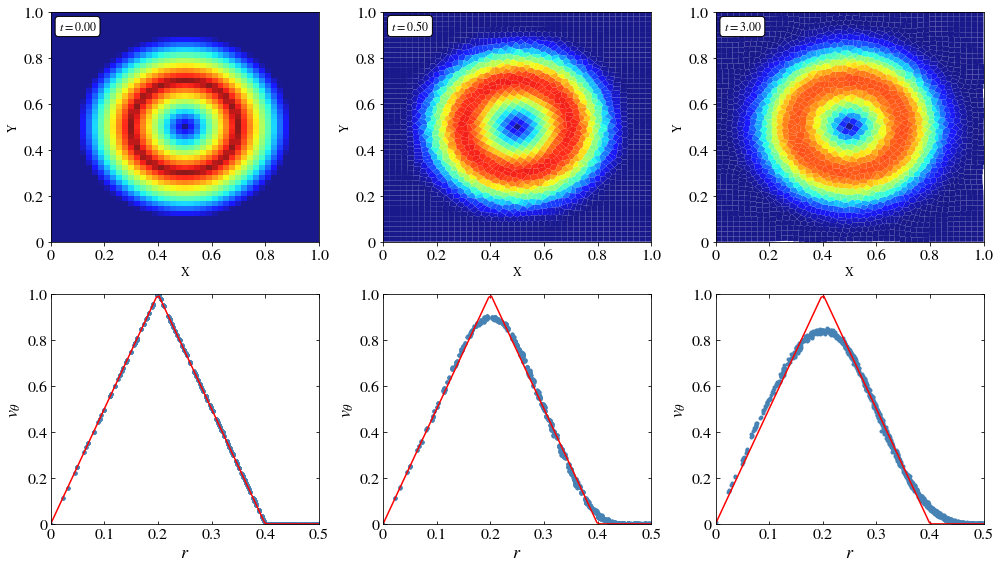

In [5]:
# imports
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams["xtick.labelsize"] = 16
mpl.rcParams["ytick.labelsize"] = 16

# create exact solution (should just reproduce the initial conditions)
radius = np.linspace(0, 0.5, 100)
sol = np.zeros(radius.size)

for i in range(sol.size):
    r = radius[i]
    if 0 <= r < 0.2:
        sol[i] = 5*r
    elif 0.2 <= r < 0.4:
        sol[i] = 2 - 5*r
    else:
        sol[i] = 0.
        
files = [
        "gresho_output/initial_output/initial_output0000/initial_output0000.hdf5",
        "gresho_output/time_interval/time_interval0000/time_interval0000.hdf5",
        "gresho_output/final_output/final_output0000/final_output0000.hdf5"
        ]

fig, axes = plt.subplots(2,3, figsize=(14,8))

for i, fi in enumerate(files):

    reader = phd.Hdf5()
    vortex, units = reader.read(fi)
    time = h5py.File(fi, "r").attrs["time"]

    # introduce two new fields for the polar coordinates
    vortex.register_carray(vortex.get_carray_size(),
            "v-theta", "double")
    vortex.register_carray(vortex.get_carray_size(),
            "rad", "double")

    # put position and velocity in polar coordinates
    theta = np.arctan2(vortex["position-y"]-0.5, vortex["position-x"]-0.5)
    vortex["rad"][:] = np.sqrt((vortex["position-x"]-0.5)**2 + (vortex["position-y"]-0.5)**2)
    vortex["v-theta"][:] = (-np.sin(theta)*vortex["velocity-x"] + np.cos(theta)*vortex["velocity-y"])

    # generate the collection of positions and corresponding velocities
    patch, colors = phd.vor_collection(vortex, "v-theta")
    vortex.remove_tagged_particles(phd.ParticleTAGS.Ghost)

    # plotting
    p = PatchCollection(patch, edgecolor="none", linewidth=0.1, cmap="jet", alpha=0.9)
    p.set_array(np.array(colors))
    p.set_clim([0, 1.0])
    ax = axes[0,i]
    ax.text(0.03, 0.92, r"$t=%0.2f$" % time, fontsize=12,
            bbox=dict(boxstyle="round", facecolor="white"))
    ax.set_xlabel("X", fontsize=12)
    ax.set_ylabel("Y", fontsize=12)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.add_collection(p)

    ax = axes[1,i]
    ax.plot(vortex["rad"], vortex["v-theta"], ".", color="steelblue", label="simulation")
    ax.plot(radius, sol, "red")
    ax.set_ylabel(r"$v_\theta$", fontsize=18)
    ax.set_xlabel(r"$r$", fontsize=18)
    ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlim(0,0.5)
    ax.set_ylim(0,1)
    ax.tick_params(direction="in", right=True, top=True)

fig.tight_layout()
plt.savefig("gresho_vortex.png")
plt.show()

Our initial grid (upper left panel) is a collection of rectangular pixels by construction. Evidently, as the system evolves, the rotating cells are deformed into irregular polygons and the angular velocity is smoothed near the sharp boundaries (at the center of the disk and the rim), but, on the whole, the system maintains the dynamical equilibrium structure of the initial conditions.